In [1]:
import sys
# in order that the parent directory can be accessed, as this notebook
# is in the 'notebooks/' subdirectory
sys.path[1:1] = ['..']
%load_ext autoreload
%autoreload 2

In [2]:
from bayesianAB.event_stream import ABtest
from bayesianAB.metrics import many_iterations
from bayesianAB.risk import risk

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## No true difference

If there is zero difference between the two means, then both the _expected loss_ and the _expected gain_ will tend towards zero. If there truly is a positive effect, the expected gain will tend towards the true positive effect, and the expected loss will tend to zero. And finally, if there truly is a negative effect, then the expected loss will tend towards the true effect and the expected gain will tend towards zero.

We see this in the next few plots. The first plot is just one experiment running to a sample size of 100, plotting the expected loss (EL, blue) and the expected gain (EG, orange).

The second plot shows 25 experiments, each running up to a sample size of 500, with the 25 traces of EL on top of each other. The third plot is the same as the second, but with a small positive true effect in order to show that the EL tends towards zero more quickly.

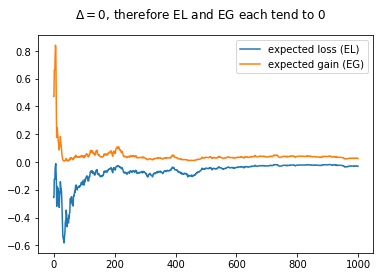

In [4]:
# run an AB test for a while and plot the expected loss
ab = ABtest.from_simple_args(true_diff=0, sd=1, weight=0.3)
losses_and_gains = many_iterations(ab, 1000)

plt.plot(losses_and_gains.expected_loss, label='expected loss (EL)');
plt.plot(losses_and_gains.expected_gain, label='expected gain (EG)');
plt.suptitle('$\Delta = 0$, therefore EL and EG each tend to $0$')
plt.legend();


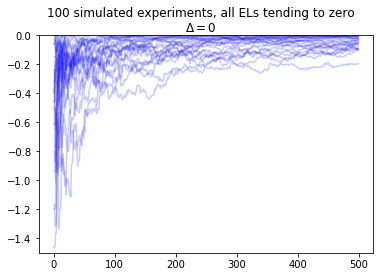

In [5]:
# run an AB test for a while and plot the expected loss
plt.suptitle("100 simulated experiments, all ELs tending to zero\n$\Delta = 0$")
plt.ylim(-1.5, 0)
for seed in range(25):
    ab = ABtest.from_simple_args(true_diff=0, sd=1, weight=0.3, seed=seed)
    losses_and_gains = many_iterations(ab, 500)
    plt.plot(losses_and_gains.expected_loss, color='blue', alpha=0.2);

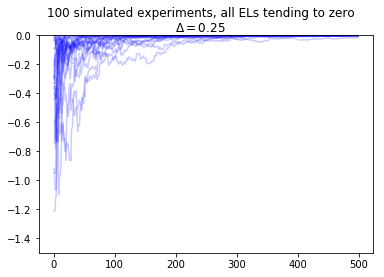

In [6]:
# run an AB test for a while and plot the expected loss
plt.suptitle("100 simulated experiments, all ELs tending to zero\n$\Delta = 0.25$")
plt.ylim(-1.5, 0)
for seed in range(25):
    ab = ABtest.from_simple_args(true_diff=0.25, sd=1, weight=0.3, seed=seed)
    losses_and_gains = many_iterations(ab, 500)
    plt.plot(losses_and_gains.expected_loss, color='blue', alpha=0.2);

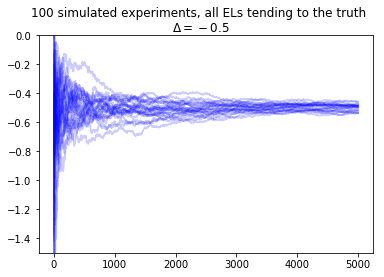

In [7]:
# run an AB test for a while and plot the expected loss
plt.suptitle("100 simulated experiments, all ELs tending to the truth \n$\Delta = -0.5$")
plt.ylim(-1.5, 0)
for seed in range(25):
    ab = ABtest.from_simple_args(true_diff=-0.5, sd=1, weight=0.3, seed=seed)
    losses_and_gains = many_iterations(ab, 5000)
    plt.plot(losses_and_gains.expected_loss, color='blue', alpha=0.2);